# Analyzing Campaign Spending
## 2016 House Election

I consider myself lucky to live in a time when democracy is considered the best and purest form of government. I would also consider myself lucky to live in a country that claims to value a "government of the people, by the people, for the people."

All of that being said, the United States has a long history of undermining this fundamental value from only allowing certain citizens to vote to modern day voter suppression laws, from having a first-pass-the-post voting system to not making election day a national holiday. However of those of concerns and more, the one concern I would like to focus on relates to campaign spending and the possible side effects of the Supreme Court ruling FEC v Citizens United. 

This whole project started with one question: **does the candidate who spends the most money during a campaign end up winning that election?** 

For the time being, I will only consider spending by the candidate's principal committee (i.e. Joe Smith for Congress). At a later date, I would like to include other committess who's aim it is to elect a specific candidate such as PAC committees, Joint committees, and ultimately Independent Expenditure-Only committess (aka Super-PACs). 

In [1]:
import requests
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from math import ceil

%matplotlib inline

In [2]:
# color palette and cmap used for graphs
cmap = plt.cm.get_cmap('Spectral')
palette = {key:cmap(i) for key, i in zip(np.linspace(0,10,11), np.linspace(0,1,11))}

# font details used for graphs
font = {'family' : 'sans-serif',
        'size'   : 18}

In [3]:
def states_and_districts():
# number of Congressional Districts per state after the 2010 census 
# 2013 was the first year with new districts

    return {
        'AL':7,
        'AK':1,
        'AZ':9,
        'AR':4,
        'CA':53,
        'CO':7,
        'CT':5,
        'DE':1,
        'FL':27,
        'GA':14,
        'HI':2,
        'ID':2,
        'IL':18,
        'IN':9,
        'IA':4,
        'KS':4,
        'KY':6,
        'LA':6,
        'ME':2,
        'MD':8,
        'MA':9,
        'MI':14,
        'MN':8,
        'MS':4,
        'MO':8,
        'MT':1,
        'NE':3,
        'NV':4,
        'NH':2,
        'NJ':12,
        'NM':3,
        'NY':27,
        'NC':13,
        'ND':1,
        'OH':16,
        'OK':5,
        'OR':5,
        'PA':18,
        'RI':2,
        'SC':7,
        'SD':1,
        'TN':9,
        'TX':36,
        'UT':4,
        'VT':1,
        'VA':11,
        'WA':10,
        'WV':3,
        'WI':8,
        'WY':1
    }

## Obtaining the 2016 House Election Results
The results for the 2016 Election (for all Federal positions) are posted on the FEC website:
https://transition.fec.gov/pubrec/electionresults.shtml

I downloaded the excel document from the link above and read in the sheet pertaining to the House of Representatives election results. This dataframe contained both the Primary and General Election results for all states and all districts with total vote counts for both, unless the Primary system for that state dictated otherwise. 

I then broke that dataframe into two seperate dataframes, one containing the raw total vote count for each district (saved as 'total_votes_house_2016.csv') and the other containing the names and candidate IDs of each candidate along with their respective total vote counts for each dictrict (saved as 'house_results_2016_clean.csv'). 

To see steps taken to 'clean' dataframe, see .....

In [4]:
results = pd.read_csv('house_results_2016_clean.csv')

In [5]:
# Total number of candidates who appeared in the 2016 House of Rep election results document
results.shape[0]

1970

In [6]:
# Number of candidates running to be a Congressional Delegate for DC or US territories 
# (Note: the Delegates voted to the House of Representatives cannot vote House matters...) 
n_delegates =\
    results[(results['STATE_ABBREVIATION'] == 'AS') |          # American Samoa
            (results['STATE_ABBREVIATION'] == 'DC') |          # District of Columbia
            (results['STATE_ABBREVIATION'] == 'GU') |          # Guam
            (results['STATE_ABBREVIATION'] == 'MP') |          # Northern Mariana Islands
            (results['STATE_ABBREVIATION'] == 'PR') |          # Puerto Rice
            (results['STATE_ABBREVIATION'] == 'VI')].shape[0]  # US Virgin Islands

n_delegates

21

In [7]:
# Number of House of Rep candidates running in the 50 US states
results.shape[0] - n_delegates

1949

## Obtaining Principal Committee IDs 
In order to determine the total amount of money directly raised and spent by a candidate, we will need to know their Principal Committee ID (i.e. House Committee). These committees must report any campaign contributions or dispursements to the FEC on a regular basis which we can then use to perform our analysis. However the 2016 House `results` dataframe only has the candidate's candidate ID number. 

The first thing that needs to be accomplished is to obtain Principal Committee IDs for each candidate who appeared in the `results` dataframe. Using the FECs API, I sent a request for more information on a candidate's Principal Committee for each candidate ID that appeared in the `results` dataframe.

I will only include candidates running in the 50 states and not those running to be Congressional Delegates in DC or the US Territories. This means I should see 1949 distinct committee IDs for each of the 1949 candidates.

To see steps used to obtain this information, see .....

In [8]:
pc = pd.read_csv('principal_committees_house_2016.csv')

In [9]:
pc.shape[0]

1349

## Combining Election Results with Principal Committee IDs
Next, I combined the two dataframes `results` and `pc` to obtain a dataframe which has both the candidate's name, ID and corresponding committee ID as well as the results of the race they were running in. Unfortunately not all of the candidates which appear in the `results` dataframe appear to have Principal Committees dataframe `pc`.

Given that the committee IDs are the vital gateway to obtaining information about a candidates campaign finances, I performed an inner merge between `results` and `pc`.

For more information on 'Candidates and their authorized committees' see:    
https://www.fec.gov/help-candidates-and-committees/guides/?tab=candidates-and-their-authorized-committees

In [10]:
# merge house results and principal committees keeping all the rows that appear 
# in the both dataframes (inner join)
# a merged copy was already created...
results_pc = pd.read_csv('house_results_pc_2016.csv')

In [11]:
results_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1349 entries, 0 to 1348
Data columns (total 13 columns):
STATE_ABBREVIATION     1349 non-null object
D                      1349 non-null int64
INCUMBENT              1349 non-null int64
CANDIDATE_NAME         1349 non-null object
CANDIDATE_ID           1349 non-null object
PARTY                  1349 non-null object
PRIMARY_VOTES          1110 non-null float64
PRIMARY_%              1109 non-null float64
GENERAL_VOTES          839 non-null float64
GENERAL_%              837 non-null float64
GE_WINNER_INDICATOR    1349 non-null int64
COMMITTEE_ID           1349 non-null object
COMMITTEE_TYPE         1349 non-null object
dtypes: float64(4), int64(3), object(6)
memory usage: 137.1+ KB


## Creating Two Dataframes Containing Results, Principal Committtee IDs and Relevant Financial Information
Below I will take the financial information obtained for each Principal Committee ID, read in as `finacial_reports`, and create one dataframe for the total funds raised (receipts) and one dataframe for the total funds spent (disbursements). These two dataframes will contain the sum of all money raised and all money spent, respectively. These two dataframes will also contain the relevant information about each candidate and how their results in the 2016 election. 

However before creating these two dataframes, I would like to determine what percentage of candidates who appeared in House Election Results dataframes have a corresponding Principal Committee ID. And further, of those candidates that have a Principal Committee, what percentage of those committees reported any funds raised or funds spent with the FEC.

In [12]:
financial_reports = pd.read_csv('financial_reports_house_2016.csv')

In [13]:
com_percent = pd.DataFrame()

for state in states_and_districts():
    df_state = results_pc[results_pc['STATE_ABBREVIATION'] == state]
    total_n_cands = results[results['STATE_ABBREVIATION'] == state]['CANDIDATE_ID'].nunique()
    
    form2_count = 0
    form3_count = 0
    for com in df_state['COMMITTEE_ID']:
        if com in results_pc['COMMITTEE_ID'].unique():
            form2_count += 1
        
        if com in financial_reports['committee_id'].unique():
            form3_count += 1

    com_percent = com_percent.append({'State' : state,
                                            'Num_Cands' : total_n_cands,
                                            'Form2' : 100*round(form2_count/total_n_cands, 2),
                                            'Form3' : 100*round(form3_count/total_n_cands, 2)},
                                          ignore_index=True)

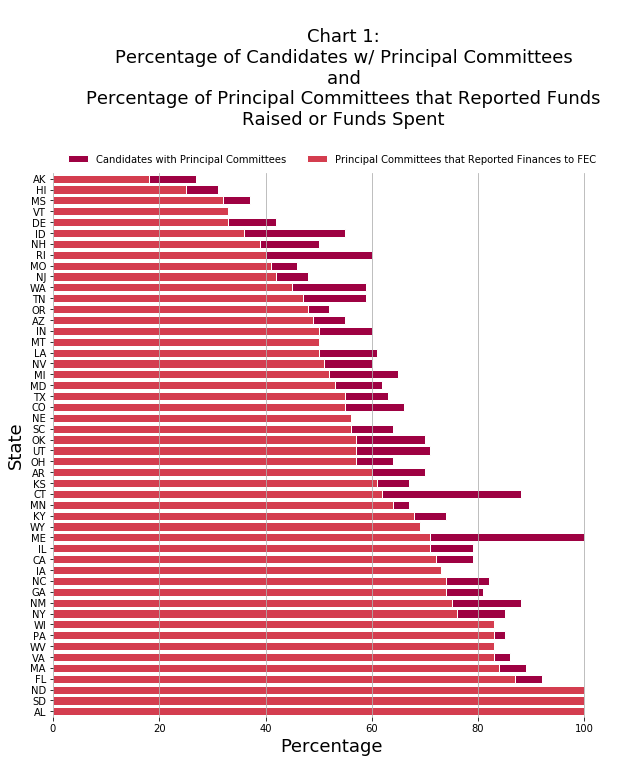

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), sharex=True)
fig.patch.set_facecolor('w')

com_percent = com_percent.sort_values('Form3')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.barh(y=com_percent['State'], width=com_percent['Form2'],
        left=0, 
        color=palette[0], edgecolor='white', height=0.75,
        label='Candidates with Principal Committees')

ax.barh(y=com_percent['State'], width=com_percent['Form3'],
        left=0, 
        color=palette[1], edgecolor='white', height=0.75,
        label='Principal Committees that Reported Finances to FEC')

ax.legend(ncol=2, bbox_to_anchor=(0.5, 1), loc='lower center', frameon=False)

ax.set_ylim(-0.5, 49.5)

ax.grid(axis='x')

ax.set_xlabel('Percentage', fontdict=font)
ax.set_ylabel('State', fontdict=font)
ax.set_title('''
    Chart 1:
    Percentage of Candidates w/ Principal Committees
    and
    Percentage of Principal Committees that Reported Funds
    Raised or Funds Spent
    ''', fontdict=font, y=1.04)

ax.invert_yaxis()

plt.show();

### Understanding Chart 1
The green bars (those Principal Committees who registered their funds raised or funds spent with the FEC) are a subset of the red-orange bars (those candidates who have registered Principal Committes with the FEC).

Since these Principal Committee IDs were obtained via an API call to the FEC using individual candidate IDs, there appear to be only three explanations for why a candidate doesn't have a Principal Committee. 
1. The most likely explanation, the candidate running in the election (probably as a candidate in the primary or a write-in candidate) didn't reach the $5000 raised or spent and therefore wasn't required by law to register as a candidate to the FEC.
    * For more details, please refer to [Instructions for Statement of Candidacy (FEC Form 2)](https://www.fec.gov/resources/cms-content/documents/fecfrm2i.pdf).
2. The candidate broke the law and simply didn't register with the FEC. This would be especially unlikely for candidates who ended up winning as their election would suddenly draw more attention. 
3. The candidate ID for one reason or another is not linked to their Principal Committee in the FEC database. 

As for why there are some candidates who have a registered Principal Committee but which never registered any of their funds raised or spent, this is more difficult to determine. One possible speculative explanation could be that the candidate filed their Statement of Candidacy before reaching the $5000 raised or spent and then never reached that threshold. 

Going forward, I would say its safe to assume the first explanation accounts for a majority, if not all, of the missing Principal Committee IDs. This assumption will allow us to safely continue with the analysis with the remaining candidates. 

In [15]:
# all relevant columns from 'financial_reports' as they relate to funds raised
funds_raised = [
    'individual_itemized_contributions_period',
    'individual_unitemized_contributions_period',
    'candidate_contribution_period',
    'political_party_committee_contributions_period',
    'other_political_committee_contributions_period',
    'transfers_from_other_authorized_committee_period',
    'loans_made_by_candidate_period',
    'all_other_loans_period',
    'offsets_to_operating_expenditures_period',
    'other_receipts_period',
    'total_receipts_period'
]

# all relevant columns from 'financial_reports' as they relate to funds spent
funds_spent = [
    'operating_expenditures_period',
    'transfers_to_other_authorized_committee_period',
    'refunded_individual_contributions_period',
    'refunded_political_party_committee_contributions_period',
    'refunded_other_political_committee_contributions_period',
    'loan_repayments_candidate_loans_period',
    'loan_repayments_other_loans_period',
    'other_disbursements_period',
    'total_disbursements_period'
]

In [16]:
def fc_total_per_com(committee_id, financial_category):
# committee_id as a string representing the committee ID 
# financial_category as a string from one of the columns from 'financial_reports'
# return the total for that category over the course of the whole election cycle

    return financial_reports[financial_reports['committee_id'] == committee_id]\
                [financial_category].sum()

In [17]:
# Determine the totals for each of the categories related to funds raised (aka receipts) 
# for each of the candidate and a create a new dataframe which contains these totals plus
# information about the candidate and their election results

fr_com = pd.DataFrame()

for com in results_pc['COMMITTEE_ID'].unique():
    df_temp = pd.DataFrame({'COMMITTEE_ID' : [com]})
    
    for fr in funds_raised:
        fct = fc_total_per_com(com, fr)
        fr_col = fr.replace('_period', '').upper()
        
        df_temp = pd.concat([df_temp, pd.DataFrame({fr_col : [fct]})], axis=1)
    
    fr_com = pd.concat([fr_com, df_temp])

results_pc_fr = results_pc.merge(fr_com, on='COMMITTEE_ID')

In [18]:
# Determine the totals for each of the categories related to funds spent (aka disbursements) 
# for each of the candidate and a create a new dataframe which contains these totals plus
# information about the candidate and their election results

fs_com = pd.DataFrame()

for com in results_pc['COMMITTEE_ID'].unique():
    df_temp = pd.DataFrame({'COMMITTEE_ID' : [com]})
    
    for fs in funds_spent:
        fct = fc_total_per_com(com, fs)
        fs_col = fs.replace('_period', '').upper()
        
        df_temp = pd.concat([df_temp, pd.DataFrame({fs_col : [fct]})], axis=1)
    
    fs_com = pd.concat([fs_com, df_temp])

results_pc_fs = results_pc.merge(fs_com, on='COMMITTEE_ID')

In [19]:
# calculate the number of candidates who spent the most money during the campaign 
# and then won the general election 
n_max_funds_win_all = {}
spent_per_com = pd.DataFrame()

for state in states_and_districts():
    # select only candidates from 'state' who appeared in the General Election
    df_state = results_pc_fs[(results_pc_fs['STATE_ABBREVIATION'] == state) & 
                             (results_pc_fs['GENERAL_%'].notnull())]
    n_max_funds_win = 0
    
    # each district in each state
    for d in df_state['D'].unique():
        # determine the index of the candidate who spent the most money
        idx_max_funds = df_state[df_state['D'] == d]['TOTAL_DISBURSEMENTS'].idxmax()
        n_max_funds_win += results_pc_fs.loc[idx_max_funds, 'GE_WINNER_INDICATOR']
    
    n_max_funds_win_all[state] = n_max_funds_win

win_loss_per_state = pd.DataFrame()

# create dataframe with win and loss percentages for each state 
for state in states_and_districts():   
    win_percent = (n_max_funds_win_all[state]/states_and_districts()[state])*100
    loss_percent = (100 - win_percent)
    
    win_loss_per_state = win_loss_per_state.append({'State' : state,
                                                    'Win_Percent' : win_percent,
                                                    'Loss_Percent' : loss_percent},
                                                  ignore_index=True)

In [20]:
print('In {} of states, all of the candidate who spent the most money also won the election.'
      .format(win_loss_per_state\
              [win_loss_per_state['Win_Percent'] == 100]['Win_Percent'].count()))

print('In {} of states, 80% of the candidate who spent the most money also won the election.'
      .format(win_loss_per_state\
              [win_loss_per_state['Win_Percent'] >= 80]['Win_Percent'].count()))


In 29 of states, all of the candidate who spent the most money also won the election.
In 43 of states, 80% of the candidate who spent the most money also won the election.


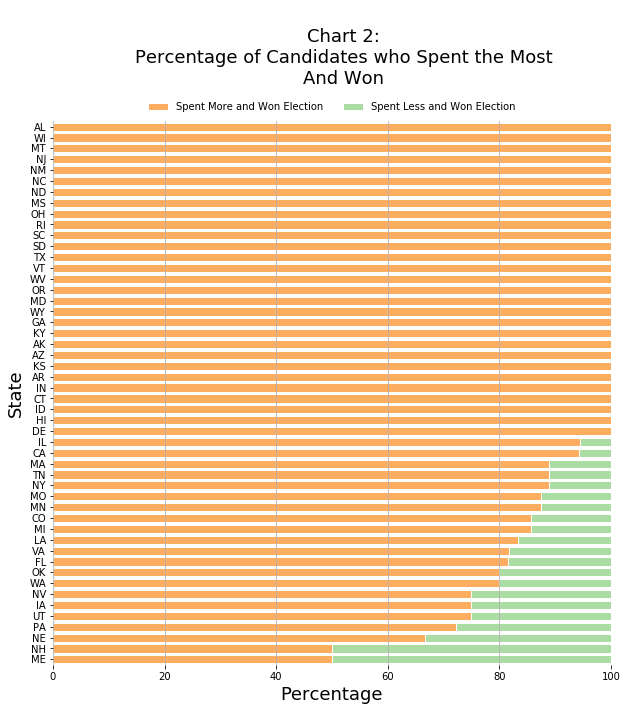

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), sharex=True)
fig.patch.set_facecolor('w')

win_loss_per_state = win_loss_per_state.sort_values('Loss_Percent')

ax.barh(win_loss_per_state['State'], win_loss_per_state['Win_Percent'],
        color=palette[3], edgecolor='white', height=0.75,
        label='Spent More and Won Election')

ax.barh(win_loss_per_state['State'], win_loss_per_state['Loss_Percent'], 
        left=win_loss_per_state['Win_Percent'],
        color=palette[7], edgecolor='white', height=0.75,
        label='Spent Less and Won Election')

ax.legend(ncol=2, bbox_to_anchor=(0.5, 1), loc='lower center', frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_ylim(-0.5, 49.5)

ax.grid(axis='x')

ax.set_xlabel('Percentage', fontdict=font)
ax.set_ylabel('State', fontdict=font)
ax.set_title('''
    Chart 2:
    Percentage of Candidates who Spent the Most
    And Won
    ''', fontdict=font, y=1.02)

ax.invert_yaxis()

plt.show();

### Understanding Chart 2
What does the graph above tell us about the candidates ability to raise and spent money and their ability to win the General Election for their district? 

Although at this time it's difficult to make causal claims about whether spending more money during an election cycle has a direct impact on their chances of winning the election, it is clear that the candidates who spent the most money during the 2016 election cycle ended up winning the vast majority of the time. For 29 states, all of the candidates who spent more ended up winning and in 43 states, 80% of the candidates who spent more ended up winning. 

There are likely many other confounding variables that haven't been taken into account but this chart is still fairly shocking and warrarnts further investigation.

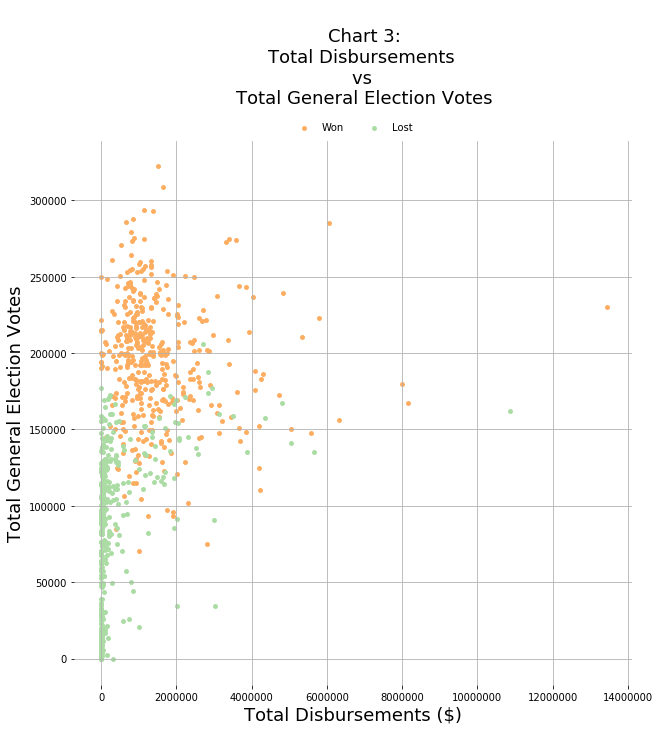

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), sharex=True)
fig.patch.set_facecolor('w')

won_ge = results_pc_fs[(results_pc_fs['GENERAL_%'].notnull()) &
                       (results_pc_fs['GE_WINNER_INDICATOR'] == 1)]
lost_ge = results_pc_fs[(results_pc_fs['GENERAL_%'].notnull()) &
                       (results_pc_fs['GE_WINNER_INDICATOR'] == 0)]

won = ax.scatter(x=won_ge['TOTAL_DISBURSEMENTS'], y=won_ge['GENERAL_VOTES'],
                 c=[palette[3]], s=15);
lost = ax.scatter(x=lost_ge['TOTAL_DISBURSEMENTS'], y=lost_ge['GENERAL_VOTES'],
                  c=[palette[7]], s=15);

# sns.scatterplot(x=results_pc_fs['TOTAL_DISBURSEMENTS'], y=results_pc_fs['GENERAL_VOTES'],
#                hue=results_pc_fs['GE_WINNER_INDICATOR'], legend=False)

ax.legend((won,lost), ('Won', 'Lost'), ncol=2, bbox_to_anchor=(0.5, 1), 
          loc='lower center', frameon=False)

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.grid(True, axis='both')

# turn off scientific notation
ax.ticklabel_format(style='plain')

ax.set_xlabel('Total Disbursements ($)', fontdict=font)
ax.set_ylabel('Total General Election Votes', fontdict=font)
ax.set_title('''
    Chart 3:
    Total Disbursements 
    vs 
    Total General Election Votes
    ''', fontdict=font, y=1.02)

plt.show()

In [23]:
for m in range(1000000,11000000, 1000000):
    n_mil_won = results_pc_fs[results_pc_fs['TOTAL_DISBURSEMENTS'] >= m]\
            ['GE_WINNER_INDICATOR'].sum()
    n_mil = results_pc_fs[results_pc_fs['TOTAL_DISBURSEMENTS'] >= m].shape[0]
    print('{p}% of candidates who spent over ${m:,}, won their election.'.format(
                p=round(100*n_mil_won/n_mil,2), m=m))

77.61% of candidates who spent over $1,000,000, won their election.
73.73% of candidates who spent over $2,000,000, won their election.
74.0% of candidates who spent over $3,000,000, won their election.
76.0% of candidates who spent over $4,000,000, won their election.
69.23% of candidates who spent over $5,000,000, won their election.
71.43% of candidates who spent over $6,000,000, won their election.
60.0% of candidates who spent over $7,000,000, won their election.
60.0% of candidates who spent over $8,000,000, won their election.
33.33% of candidates who spent over $9,000,000, won their election.
33.33% of candidates who spent over $10,000,000, won their election.


### Understanding Chart 3
The orange dots, which represent the candidates that won in the general election appear to cluster above the green dots which represent the candidates that lost in the general election. This makes sense since the winners of the general election need higher vote counts in order to win their election.

The other observation is that those candidates who spent over $1M tend to win at quite a high rate (77.61\%). And from what we saw in Chart 2 above, we see a similar trend: those candidates who spent more, tend the win their election. 

Again, we still can't definitively say anything about there being a causal relationship between a candidate spending money during an election and them winning that election, but we are starting to tease out a trend. 

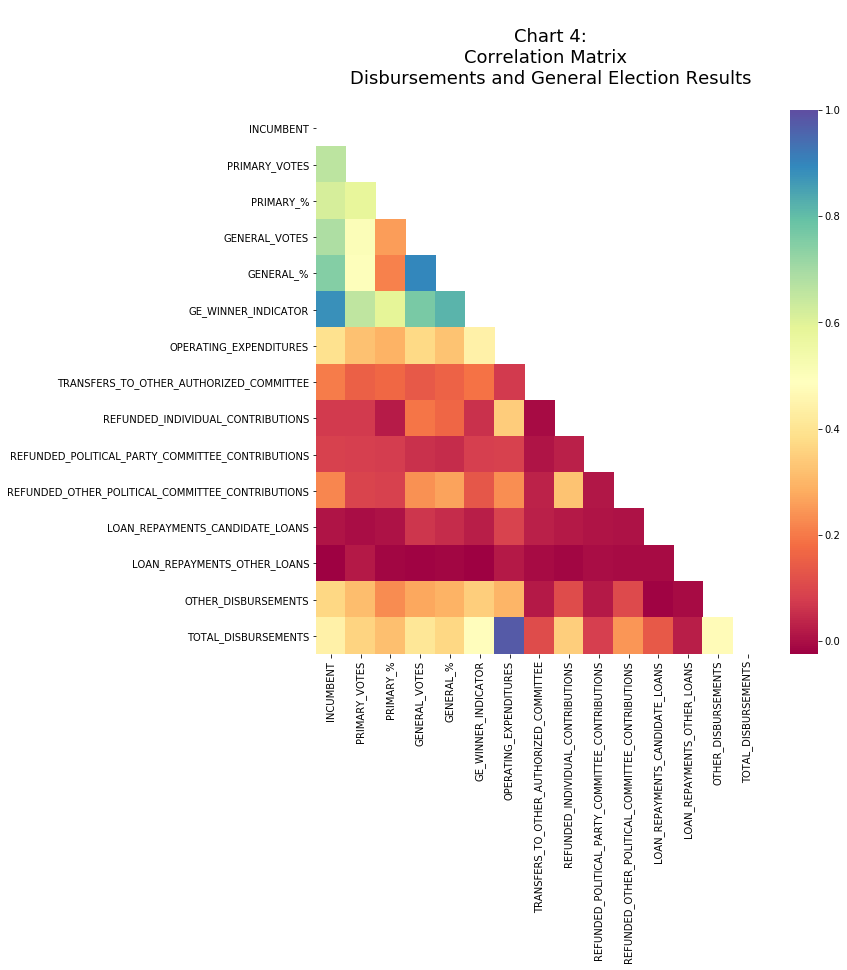

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), sharex=True)
fig.patch.set_facecolor('w')

corr = results_pc_fs.drop('D', axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap=cmap);

ax.set_title('''
    Chart 4:
    Correlation Matrix  
    Disbursements and General Election Results
    ''', fontdict=font, y=1.02)

plt.show()

### Understanding Chart 4
The chart above is close look at the correlation between the different numerical columns representing how a candidate and their committee raised money and their election results. It appears that a majority of the financial columns have no bearing on how well the candidate did in the election, represented by the orange to red colored squares. 

There appears to be a strong correlation between total disbursements and operating expenditures. This makes sense since operating expeditures represents the vast majority of where the candidates would spent their money (from FEC: 'day-to-day expenditures for items such as rent, overhead, administration, personnel, equipment, travel, advertising and fundraising'). There also appears to be about moderate correlation between total disbursements and general election winner indictor. The fact that there appears to be some correlation doesn't seem too suprising given the analysis we've performed above. 

Lastly, there also appears to be a strong correlation between incumbent and general election winner indictor. This means that most candidates running for re-election tend to win. 

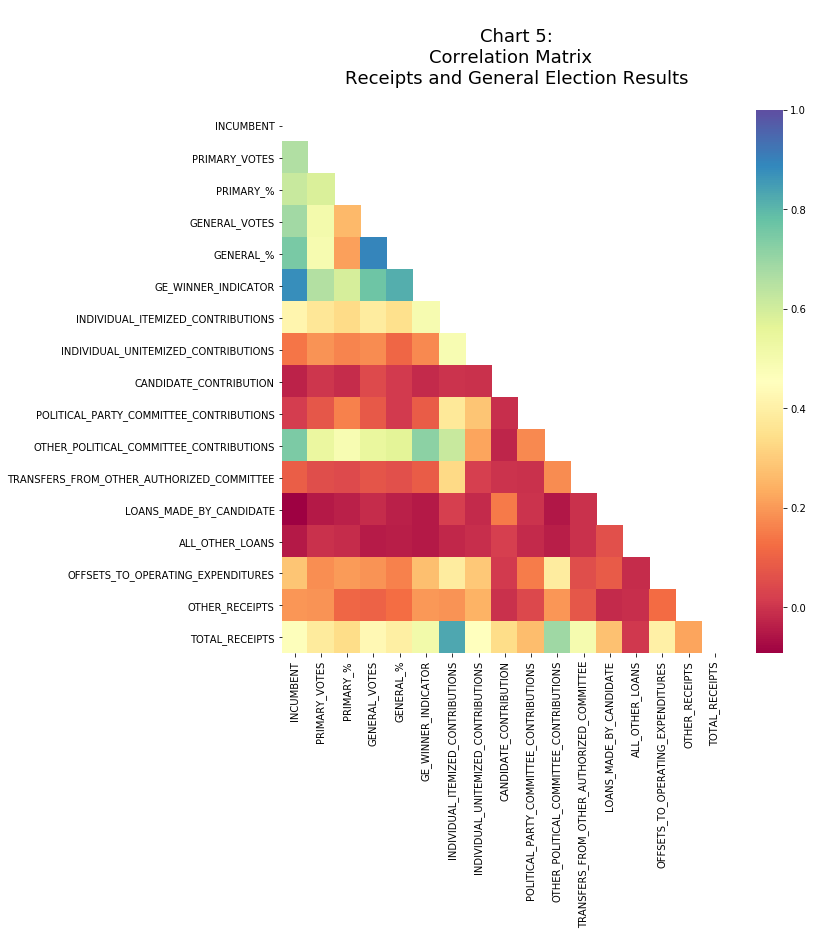

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), sharex=True)
fig.patch.set_facecolor('w')

corr = results_pc_fr.drop('D', axis=1).corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(corr, mask=mask, cmap=cmap);

ax.set_title('''
    Chart 5:
    Correlation Matrix  
    Receipts and General Election Results
    ''', fontdict=font, y=1.02)

plt.show()

### Understanding Chart 5
This is another correlation matrix, similar to the one above however this time we are looking at the relationship between where the candidates and their committess received their funding from. There appears to be a strong and moderately strong correlation between individual itemized contributions and total receipts and other political committee contributions and total receipts respectively. This implies that a major source of funding for campaigns come from individuals who donate more than \\$200 (donations greater than $200 must be itemized, see [link](https://www.fec.gov/help-candidates-and-committees/filing-reports/individual-contributions/) for more details) and from other political committees (see [link](https://www.fec.gov/help-candidates-and-committees/filing-reports/pacs-other-political-committee-contributions/) for more details).

In [26]:
fcp_per_state = pd.DataFrame()

for state in states_and_districts():
    df_temp = pd.DataFrame({'STATE' : [state]})
    
    for fr in funds_raised[:-1]:
        fr_col = fr.replace('_period', '').upper()
        fcp = 100*results_pc_fr[results_pc_fr['STATE_ABBREVIATION'] == state][fr_col].sum()/\
                results_pc_fr[results_pc_fr['STATE_ABBREVIATION'] == state]\
                                                ['TOTAL_RECEIPTS'].sum()        
        
        df_temp = pd.concat([df_temp, pd.DataFrame({fr_col : [fcp]})], axis=1)
    
    fcp_per_state = pd.concat([fcp_per_state, df_temp])
        

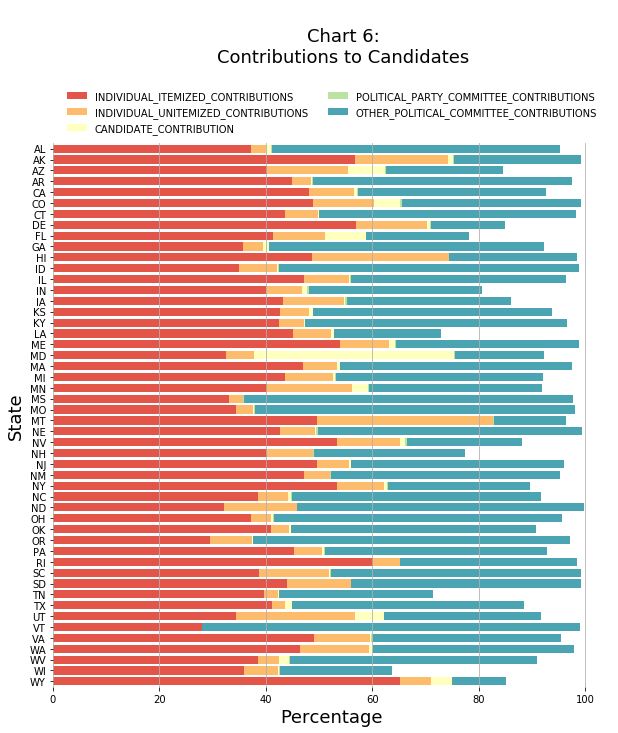

In [27]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10), sharex=True)
fig.patch.set_facecolor('w')

# only include contribution columns 
# (exclude 'Transfers from other authorized committes', 'loans made by candidates',
# 'other loans', 'offsets to operating expenditures', and 'other receipts')
cat_names = []
for fr in funds_raised[:5]:
    cat_names.append(fr.replace('_period', '').upper())
    
state_list = []
for st in states_and_districts():
    state_list.append(st)

data = fcp_per_state[cat_names].values
data_cum = data.cumsum(axis=1)
category_colors = plt.get_cmap(cmap)(np.linspace(0.15, 0.85, data.shape[1]))

for i, (colname, color) in enumerate(zip(cat_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(state_list, widths, left=starts, height=0.75,
                label=colname, color=color)

ax.legend(ncol=2, bbox_to_anchor=(0.5, 1), loc='lower center', frameon=False)

ax.set_ylim(-0.5, 49.5)
ax.invert_yaxis()
        
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_xlabel('Percentage', fontdict=font)
ax.set_ylabel('State', fontdict=font)
ax.set_title('''
    Chart 6:
    Contributions to Candidates
    ''', fontdict=font, y=1.1)

ax.grid(axis='x')

plt.show();

### Understanding Chart 6 
This chart comfirms what we discovered in the previous slide which is that a majority of funding for most campaigns come in the form of individual itemized contributions ($200 or more) and from other political committees (PACS, other candidates, etc). 

## Wrap Up 
This analysis looked at the available Principal Committees and their finances for all of the candidates who ran in the 2016 House of Representative elections. The question that was posed at the beginning of the analysis was, do the campaigns that spend the most money duing an election cycle end up winning the general election? 

The answer appears to be yes. This doesn't mean that this is always the case or that the correlation is particularly strong but the analysis show there appears to be some kind of relationship money spent and election results. There are surely other factors and confounding variables involved such as whether or not the candidate was an incumbent or what the political leaning of the district in question looks like, however this analysis ultimately sparks in me a desire to keep digging. 

This will be considered version 1. There are a lot more questions and other avenues through which to analyze the affect money has on election results and I intend to explore those further in the months to come. Here are a few thoughts and ideas I would like to explore:
* Perform a more in depth analysis of the Primary Election 
* Perform a similar analysis for other years 
* Perform a similar analysis for Senate and Presidential races
* Include other political committees in my analysis such as Joint Committees, PACs and Super PACs
* Create a Machine Learning algorith to predict the winners for upcoming elections